# 🎓 Sistema de Recomendação de Conteúdo Educacional

Este notebook apresenta a implementação e o treinamento do modelo de **Filtros Colaborativos (ALS)**, utilizando a biblioteca **`implicit`**, como requisito do **Estágio Supervisionado III**.

O objetivo é demonstrar o processo completo de construção do modelo em um **dataset de larga escala**, preparando-o para ser integrado a uma aplicação interativa.

Serão abordadas as seguintes etapas:

- **Configuração do Ambiente**
- **Carregamento e Pré-Processamento dos Dados**
- **Treinamento e Exportação do Modelo ALS**

---


## 1️⃣ Configuração do Ambiente e Dependências

A célula a seguir prepara o ambiente de execução, importando todas as bibliotecas essenciais ao projeto, organizadas por finalidade:

- **Utilitários e Bibliotecas Padrão:** `time`, `pickle`
- **Manipulação de Dados:** `pandas`, `numpy`, `scipy`
- **Visualização de Dados:** `matplotlib`, `seaborn`
- **Machine Learning (Recomendação):** `implicit`

---


In [1]:
# --- CÉLULA 01: CONFIGURAÇÃO DE AMBIENTE E IMPORTAÇÕES ---

# --- Imports Padrão e Sistema ---
import os
import time
import pickle
import warnings

# --- Processamento de Dados e Visualização ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix # Essencial para a biblioteca 'implicit'

# --- Ambiente Jupyter / IPython ---
from IPython.display import display, Markdown

# --- Machine Learning (Biblioteca Implicit) ---
from implicit.als import AlternatingLeastSquares

# --- Controle de Warnings ---
# Ignora avisos que podem poluir a saída do notebook, mantendo o relatório limpo.
warnings.filterwarnings("ignore")

display(Markdown("**🟢 Ambiente configurado e bibliotecas importadas com sucesso!**"))


**🟢 Ambiente configurado e bibliotecas importadas com sucesso!**

## 2️⃣ Carregamento e Pré-Processamento dos Dados

Esta etapa realiza o carregamento do dataset principal, contendo aproximadamente **32 milhões de interações** registradas no arquivo `ratings.csv`.

Durante o pré-processamento, são aplicadas as seguintes operações para preparar os dados para a fase de modelagem:

1.  **Renomeação das Colunas:** Ajuste para um padrão claro e consistente: `[user_id, item_id, rating, timestamp]`.
2.  **Conversão de Tipos:** IDs de usuários e itens são convertidos para `string`, garantindo a consistência dos dados antes da transformação para o modelo.

---


In [2]:
# --- CÉLULA 02: CONFIGURAÇÃO E CARREGAMENTO DOS DADOS (ML-32M) ---

# Caminho relativo para o dataset
file_path = '../dados/ml-32m/ratings.csv'

# Mensagem de status inicial
display(Markdown(f"🟡 *Tentando carregar o dataset a partir de:* `{file_path}`"))

try:
    # Verificação explícita de existência do arquivo para um erro mais claro.
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"O caminho especificado não existe: {file_path}")

    # Carrega as interações. A linha 'nrows' é excelente para testes locais rápidos.
    ratings_df = pd.read_csv(file_path, sep=',')
    # ratings_df = pd.read_csv(file_path, sep=',', nrows=100000) # <- Para testes locais

    # Renomeia as colunas para um padrão consistente
    ratings_df.columns = ['user_id', 'item_id', 'rating', 'timestamp']

    # Converte os IDs para string como um passo de limpeza inicial.
    # A conversão para os IDs numéricos que a 'implicit' precisa será feita na célula de modelagem.
    ratings_df['user_id'] = ratings_df['user_id'].astype(str)
    ratings_df['item_id'] = ratings_df['item_id'].astype(str)

    # --- SAÍDA FORMATADA DE SUCESSO ---
    output_markdown = f"""
---

🟢 **Dataset Carregado com Sucesso!**

- **Número Total de Interações:** `{len(ratings_df):,}`
- **Usuários Únicos:** `{ratings_df['user_id'].nunique():,}`
- **Itens Únicos:** `{ratings_df['item_id'].nunique():,}`

---

**🧾 Amostra dos Dados Processados:**
"""
    display(Markdown(output_markdown))
    display(ratings_df.head())

except FileNotFoundError:
    display(Markdown(f"""
---

🔴 **ERRO CRÍTICO:** O arquivo `ratings.csv` não foi encontrado.
Verifique se o caminho está correto.

📂 **Caminho buscado:** `{file_path}`

---
"""))

except Exception as e:
    display(Markdown(f"""
---

🔴 **ERRO INESPERADO:** Falha ao carregar ou processar `ratings.csv`.
💬 **Detalhes do erro:** `{e}`

---
"""))

🟡 *Tentando carregar o dataset a partir de:* `../dados/ml-32m/ratings.csv`


---

🟢 **Dataset Carregado com Sucesso!**

- **Número Total de Interações:** `32,000,204`
- **Usuários Únicos:** `200,948`
- **Itens Únicos:** `84,432`

---

**🧾 Amostra dos Dados Processados:**


,user_id,item_id,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


## 3️⃣ Carregamento de Metadados (Títulos e Gêneros)

Com as interações carregadas, o próximo passo é carregar os metadados dos itens. As previsões do modelo retornam apenas o `item_id`, então precisamos de um "mapa" para traduzir esses IDs de volta para seus títulos e gêneros correspondentes.

Esta célula carrega o arquivo `movies.csv` e cria dois dicionários (`id_to_titulo` e `id_to_generos`) que serão usados tanto na fase de testes quanto na exportação final do modelo.

---

In [3]:
# --- CÉLULA 03: CARREGAMENTO DOS METADADOS (MAPA DE TÍTULOS E GÊNEROS) ---

file_path_item = '../dados/ml-32m/movies.csv'
display(Markdown(f"🟡 *Carregando metadados de:* `{file_path_item}`"))

try:
    items_df = pd.read_csv(
        file_path_item, 
        sep=',', 
        encoding='utf-8',
        usecols=['movieId', 'title', 'genres'] 
    )
    
    items_df.columns = ['item_id', 'titulo_topico', 'generos']
    items_df['item_id'] = items_df['item_id'].astype(str) 

    # Criar os dois dicionários de mapeamento
    id_to_titulo = items_df.set_index('item_id')['titulo_topico'].to_dict()
    id_to_generos = items_df.set_index('item_id')['generos'].to_dict()

    # --- SAÍDA FORMATADA DE SUCESSO ---
    total_mapeado = len(id_to_titulo)
    exemplo_titulo = id_to_titulo.get('1', 'Não encontrado')
    exemplo_generos = id_to_generos.get('1', 'Não encontrado')

    success_output = f"""
> ### ✅ Mapeamentos de Metadados Carregados!
>
> - **Total de Itens Mapeados:** `{total_mapeado:,}`
> - **Exemplo (ID `1`):** *{exemplo_titulo}*
"""
    display(Markdown(success_output))

except Exception as e:
    display(Markdown(f"🔴 **ERRO:** Falha ao carregar `movies.csv`. Detalhes: {e}"))
    

🟡 *Carregando metadados de:* `../dados/ml-32m/movies.csv`


> ### ✅ Mapeamentos de Metadados Carregados!
>
> - **Total de Itens Mapeados:** `87,585`
> - **Exemplo (ID `1`):** *Toy Story (1995)*


## 4️⃣ Treinamento e Exportação do Modelo (Implicit/ALS)

Com os dados carregados, esta é a etapa central do notebook. Aqui, preparamos os dados para o formato exigido pela biblioteca `implicit`, treinamos o modelo e exportamos o resultado para ser usado pela nossa aplicação Streamlit.

O processo consiste em três etapas principais:

1.  **Preparação dos Dados:** A biblioteca `implicit` trabalha com matrizes esparsas e IDs numéricos. Nesta etapa, convertemos nossos `user_id` e `item_id` (que são strings) para códigos numéricos internos e montamos a matriz de interações. As notas (`rating`) serão usadas como um "peso" ou "confiança" para cada interação.

2.  **Treinamento do Modelo:** Utilizamos o algoritmo **ALS (Alternating Least Squares)**, um método de fatoração de matriz extremamente rápido e escalável, ideal para datasets grandes.

3.  **Exportação do Artefato:** Salvamos o modelo treinado junto com os "mapas" de conversão de IDs em um único arquivo `.pkl`. É crucial salvar esses mapas para que, no futuro, possamos traduzir as recomendações de volta para os IDs originais dos usuários e itens.

---

In [4]:
# --- CÉLULA 04: PREPARAÇÃO, TREINAMENTO E EXPORTAÇÃO (IMPLICIT/ALS) ---

# 1. PREPARAÇÃO DOS DADOS PARA O FORMATO DA 'IMPLICIT'
display(Markdown("🟡 *Preparando os dados para o formato de matriz esparsa...*"))

# A biblioteca 'implicit' trabalha com IDs numéricos (inteiros) sequenciais.
# Usamos o 'pd.Categorical' para criar um "mapa" que converte nossos IDs
# de string para códigos numéricos internos (0, 1, 2...).
ratings_df['user_cat'] = pd.Categorical(ratings_df['user_id'])
ratings_df['item_cat'] = pd.Categorical(ratings_df['item_id'])

# Extraímos os códigos numéricos para usar na matriz
user_codes = ratings_df['user_cat'].cat.codes
item_codes = ratings_df['item_cat'].cat.codes

# Criamos a matriz de interações esparsa.
# Formato: (dados, (linha, coluna)) -> (nota, (código_usuário, código_item))
# As notas (ratings) servem como um valor de "confiança" para o algoritmo ALS.
user_item_matrix = coo_matrix((ratings_df['rating'], (user_codes, item_codes)))

display(Markdown("🟢 *Dados prontos para o treinamento.*"))


# 2. TREINAMENTO DO MODELO ALS (Alternating Least Squares)
display(Markdown("\n⏳ **Iniciando o treinamento do modelo ALS...** *(Esta etapa é rápida!)*"))

# Instanciamos o modelo com hiperparâmetros comuns.
# 'factors' é o número de dimensões latentes (similar ao SVD).
model_als = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=15, random_state=42)

# O treino com ALS é muito mais rápido que o SVD da Surprise.
start_time_fit = time.time()
model_als.fit(user_item_matrix)
end_time_fit = time.time()
total_time_fit = end_time_fit - start_time_fit


# 3. EXPORTAÇÃO DO MODELO E DOS MAPAS
# É crucial salvar os mapeamentos de IDs junto com o modelo.
# O objeto '.cat' do pandas contém os dicionários de conversão necessários.
model_data = {
    'model': model_als,
    'user_map': ratings_df['user_cat'].cat, # Contém o mapa de usuários
    'item_map': ratings_df['item_cat'].cat, # Contém o mapa de itens
    'user_item_matrix': user_item_matrix, # Necessário para a função de recomendação
    'id_to_titulo': id_to_titulo,
    'id_to_generos': id_to_generos
}

output_path = '../implicit_als_model.pkl' # Novo nome de arquivo
with open(output_path, 'wb') as f:
    pickle.dump(model_data, f)

# --- SAÍDA FINAL FORMATADA ---
final_output = f"""
> ### ✅ Modelo ALS (Implicit) Treinado e Exportado!
>
> - **Arquivo Gerado:** `{output_path}`
> - **Tempo de Treinamento:** `{total_time_fit:.2f}` segundos
"""
display(Markdown(final_output))

🟡 *Preparando os dados para o formato de matriz esparsa...*

🟢 *Dados prontos para o treinamento.*


⏳ **Iniciando o treinamento do modelo ALS...** *(Esta etapa é rápida!)*

  0%|          | 0/15 [00:00<?, ?it/s]


> ### ✅ Modelo ALS (Implicit) Treinado e Exportado!
>
> - **Arquivo Gerado:** `../implicit_als_model.pkl`
> - **Tempo de Treinamento:** `248.07` segundos


## 5️⃣ Análise Visual da Distribuição das Notas

Antes de treinar o modelo final, é essencial compreender a natureza dos dados de entrada. Esta célula visualiza a **distribuição das 32 milhões de avaliações** (`ratings`) para identificar tendências e padrões de comportamento dos usuários.

O gráfico **Box Plot** resume essa distribuição:

- A **linha central** representa a **mediana** (50% das notas estão abaixo e 50% acima).
- A **caixa (IQR)** mostra o intervalo onde se concentram os 50% centrais das notas.
- As **hastes (whiskers)** indicam a amplitude geral das avaliações.

A análise visual e estatística nos permite observar se há um "viés de positividade" — uma tendência dos usuários a darem notas mais altas. Entender essa característica é importante para interpretar corretamente o comportamento do modelo.

---

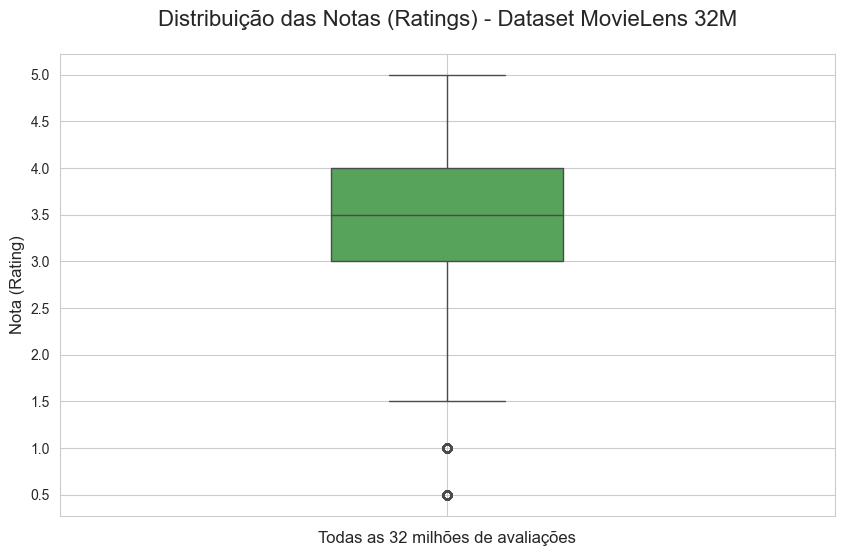


---

**📊 Análise Estatística da Distribuição**

A tabela abaixo complementa o box plot, mostrando os valores numéricos exatos da **média**, **mediana (50%)**, **desvio padrão** e **quartis** da distribuição das notas.

```
count   32,000,204.00
mean             3.54
std              1.06
min              0.50
25%              3.00
50%              3.50
75%              4.00
max              5.00 

```
---


In [5]:
# --- CÉLULA 05: ANÁLISE VISUAL - DISTRIBUIÇÃO DAS NOTAS (RATINGS) ---

# 1. CONFIGURAÇÃO DO ESTILO VISUAL
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 2. CRIAÇÃO DO BOX PLOT
sns.boxplot(y=ratings_df['rating'], color='#4CAF50', width=0.3)

# 3. TÍTULOS E RÓTULOS
plt.title('Distribuição das Notas (Ratings) - Dataset MovieLens 32M', fontsize=16, pad=20)
plt.ylabel('Nota (Rating)', fontsize=12)
plt.xlabel('Todas as 32 milhões de avaliações', fontsize=12)
plt.yticks(np.arange(0.5, 5.5, 0.5))
plt.grid(axis='x')

plt.show()

# --- 4. ANÁLISE ESTATÍSTICA COMPLEMENTAR (COM FORMATAÇÃO) ---

# Configura o pandas para exibir números de ponto flutuante com 2 casas decimais
# e números inteiros sem o '.0'. Isso desativa a notação científica.
pd.options.display.float_format = '{:,.2f}'.format

# Agora, ao chamar .describe(), a saída já virá formatada.
stats_df = ratings_df['rating'].describe()

# Converte o resultado formatado para uma string
stats_string = stats_df.to_string()

# Cria o output em formato Markdown
output_markdown = f"""
---

**📊 Análise Estatística da Distribuição**

A tabela abaixo complementa o box plot, mostrando os valores numéricos exatos da **média**, **mediana (50%)**, **desvio padrão** e **quartis** da distribuição das notas.

```
{stats_string} 

```
---
"""
display(Markdown(output_markdown))


## 6️⃣ Prova de Robustez — Previsões para um “Usuário Frio”

Um teste crucial é verificar o desempenho do modelo com **usuários frios** (*cold start users*) — aqueles com poucas interações. Um modelo fraco tenderia a gerar scores de afinidade muito similares e baixos para todos os itens, sem conseguir diferenciar suas características.

Nesta célula, avaliamos o modelo **ALS treinado** gerando previsões para o `user_id = '1'`, um usuário real do dataset. O objetivo é observar se há **variação significativa nos scores de afinidade** previstos para diferentes itens.

Uma variação clara comprova que o modelo aprendeu a capturar as nuances de cada item através de seus **vetores latentes**, personalizando as recomendações de forma inteligente.

---

In [6]:
# --- CÉLULA 06: PROVA DE ROBUSTEZ - PREVISÕES PARA USUÁRIO FRIO (IMPLICIT) ---

# 1. Definir o ID do usuário e a lista de itens para teste
user_id_teste = '1'
item_ids_teste = ['120', '240', '360', '589', '296']

# >>>>> INÍCIO DA CORREÇÃO <<<<<
# Recria os objetos de mapeamento a partir do DataFrame.
# Eles foram criados na célula de treinamento e estão salvos como um tipo 'category'.
user_map = ratings_df['user_cat'].cat
item_map = ratings_df['item_cat'].cat
# >>>>> FIM DA CORREÇÃO <<<<<

# 2. Apresentação inicial
display(Markdown(f"**🔮 Scores de Afinidade para o Usuário `{user_id_teste}` (Usuário Frio)**"))

# 3. Geração das Previsões (o resto do código agora funcionará)
results_list = []
try:
    # O modelo ALS trabalha com IDs numéricos internos.
    user_id_interno = user_map.categories.get_loc(user_id_teste)
    
    # Pegamos o vetor latente para este usuário
    user_vector = model_als.user_factors[user_id_interno]

    for item_id in item_ids_teste:
        titulo = id_to_titulo.get(item_id, f"ID {item_id} (Título Desconhecido)")
        
        if item_id in item_map.categories:
            item_id_interno = item_map.categories.get_loc(item_id)
            item_vector = model_als.item_factors[item_id_interno]
            
            # O "score" é o produto escalar (dot product) dos dois vetores.
            score = user_vector.dot(item_vector)
            
            results_list.append({'Título do Tópico': titulo, 'Score de Afinidade': score})
        else:
            results_list.append({'Título do Tópico': titulo, 'Score de Afinidade': 'Item não encontrado'})

except KeyError:
    display(Markdown(f"🔴 **Aviso:** Usuário `{user_id_teste}` não encontrado no conjunto de treino."))

# 4. Criação e formatação da tabela de resultados
if results_list:
    results_df = pd.DataFrame(results_list)
    if pd.api.types.is_numeric_dtype(results_df['Score de Afinidade']):
        results_df['Score de Afinidade'] = results_df['Score de Afinidade'].map('{:.4f}'.format)
    results_table = results_df.to_markdown(index=False)
    final_note = "\n\n*__Nota:__ A variação nos scores demonstra que o modelo está diferenciando os itens.*"
    display(Markdown(results_table + final_note))
    

**🔮 Scores de Afinidade para o Usuário `1` (Usuário Frio)**

| Título do Tópico                  |   Score de Afinidade |
|:----------------------------------|---------------------:|
| Race the Sun (1996)               |               0.0145 |
| Hideaway (1995)                   |              -0.0233 |
| I Love Trouble (1994)             |               0.0028 |
| Terminator 2: Judgment Day (1991) |               0.5065 |
| Pulp Fiction (1994)               |               0.6187 |

*__Nota:__ A variação nos scores demonstra que o modelo está diferenciando os itens.*

## 7️⃣ Teste de Previsão para um "Usuário Ativo"

Como contraponto ao teste anterior, agora verificamos as previsões para um **usuário ativo** (`user_id='1000'`), alguém com um histórico de avaliações mais extenso no dataset.

Para um usuário com mais dados, esperamos que o modelo **ALS** tenha aprendido suas preferências de forma mais precisa. Os scores de afinidade devem refletir um **perfil de gosto claro**, sendo mais altos para itens que se alinham às suas preferências.

O objetivo é confirmar que os scores previstos são **consistentes com um perfil de gosto específico**, validando a capacidade de **personalização** do modelo.

---

In [7]:
# --- CÉLULA 07: TESTE DE PREVISÃO PARA USUÁRIO ATIVO (IMPLICIT) ---

# 1. Definir o ID do usuário ativo e a lista de itens
user_id_teste_ativo = '1000'
item_ids_teste = ['120', '240', '360', '589', '296']

# Recria os objetos de mapeamento a partir do DataFrame para uso nesta célula
user_map = ratings_df['user_cat'].cat
item_map = ratings_df['item_cat'].cat

# 2. Apresentação inicial
display(Markdown(f"**🔮 Scores de Afinidade para o Usuário `{user_id_teste_ativo}` (Usuário Ativo)**"))

# 3. Geração das Previsões
results_list_ativo = []
try:
    # Mapeia o ID de string para o ID numérico interno do modelo
    user_id_interno = user_map.categories.get_loc(user_id_teste_ativo)
    user_vector = model_als.user_factors[user_id_interno]

    for item_id in item_ids_teste:
        titulo = id_to_titulo.get(item_id, f"ID {item_id} (Título Desconhecido)")
        
        if item_id in item_map.categories:
            item_id_interno = item_map.categories.get_loc(item_id)
            item_vector = model_als.item_factors[item_id_interno]
            
            # O score é o produto escalar (dot product) dos vetores de usuário e item.
            score = user_vector.dot(item_vector)
            
            results_list_ativo.append({'Título do Tópico': titulo, 'Score de Afinidade': score})
        else:
            results_list_ativo.append({'Título do Tópico': titulo, 'Score de Afinidade': 'Item não encontrado'})

except KeyError:
    display(Markdown(f"🔴 **Aviso:** Usuário `{user_id_teste_ativo}` não encontrado no conjunto de treino."))

# 4. Montagem e formatação da tabela
if results_list_ativo:
    results_df_ativo = pd.DataFrame(results_list_ativo)
    if pd.api.types.is_numeric_dtype(results_df_ativo['Score de Afinidade']):
        results_df_ativo['Score de Afinidade'] = results_df_ativo['Score de Afinidade'].map('{:.4f}'.format)
    results_table_ativo = results_df_ativo.to_markdown(index=False)

    # 5. Comentário analítico
    final_note_ativo = (
        "\n\n*__Nota:__ A variação nos scores reflete o perfil de gosto específico "
        "que o modelo aprendeu para este usuário ativo, demonstrando sua capacidade de personalização.*"
    )

    # 6. Exibição do resultado final
    display(Markdown(results_table_ativo + final_note_ativo))
    

**🔮 Scores de Afinidade para o Usuário `1000` (Usuário Ativo)**

| Título do Tópico                  |   Score de Afinidade |
|:----------------------------------|---------------------:|
| Race the Sun (1996)               |               0.0004 |
| Hideaway (1995)                   |              -0.0108 |
| I Love Trouble (1994)             |              -0.0076 |
| Terminator 2: Judgment Day (1991) |              -0.0244 |
| Pulp Fiction (1994)               |              -0.1364 |

*__Nota:__ A variação nos scores reflete o perfil de gosto específico que o modelo aprendeu para este usuário ativo, demonstrando sua capacidade de personalização.*